In [93]:
import os.path as path
from dataclasses import dataclass
import json
import os

import torch as t
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import sklearn.preprocessing as skprep

import torchutils as tu
from torchutils.ml_loggers.csv_logger import CsvMLExperiment
from torchutils.ml_loggers.stdout_logger import StdoutMLExperiment
from torchutils.visualizers.csv_metrics_visualizer import compare, analyze

import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from haikunator import Haikunator

# Prep Dataset

In [2]:
DATAROOT = path.expanduser("~/mldata/ghosts")

In [3]:
ghosts_df = pd.read_csv(path.join(DATAROOT, "train.csv"), index_col="id")

In [4]:
ghosts_df.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
id,,,,,,
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [5]:
ghosts_df.groupby("type").size()

type
Ghost     117
Ghoul     129
Goblin    125
dtype: int64

In [6]:
ghosts_df.groupby("color").size()

color
black     41
blood     12
blue      19
clear    120
green     42
white    137
dtype: int64

In [7]:
color_encoder = skprep.LabelBinarizer()
color_encoder.fit(ghosts_df["color"])
color_encoder.classes_

array(['black', 'blood', 'blue', 'clear', 'green', 'white'], dtype='<U5')

In [8]:
encoded_colors = color_encoder.transform(ghosts_df["color"])
encoded_colors[:3]

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0]])

In [9]:
X = ghosts_df[["bone_length", "rotting_flesh", "hair_length", "has_soul"]].values
print(X.shape, X.dtype)
X[:3]

(371, 4) float64


array([[0.35451218, 0.35083903, 0.46576089, 0.78114167],
       [0.57555991, 0.42586843, 0.53140138, 0.43989888],
       [0.4678755 , 0.35433042, 0.81161609, 0.79122497]])

In [10]:
X = np.concatenate((X, encoded_colors), axis=1)
print(X.shape)
X[:3]

(371, 10)


array([[0.35451218, 0.35083903, 0.46576089, 0.78114167, 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.57555991, 0.42586843, 0.53140138, 0.43989888, 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.4678755 , 0.35433042, 0.81161609, 0.79122497, 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [11]:
type_encoder = skprep.LabelEncoder()
type_encoder.fit(ghosts_df["type"])
type_encoder.classes_

array(['Ghost', 'Ghoul', 'Goblin'], dtype=object)

In [12]:
y = type_encoder.transform(ghosts_df["type"])
print(y.shape)
y[:5]

(371,)


array([1, 2, 1, 1, 0])

In [13]:
dataset = TensorDataset(t.from_numpy(X).to(t.float32), t.from_numpy(y).to(t.int64))

In [14]:
train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, (train_size, val_size))
print(len(trainset), len(valset))

333 38


# Train Model

In [15]:
h = Haikunator()

In [16]:
@dataclass
class MyHyperparams(tu.Hyperparams):
    batch_size: int
    n_epochs: int
    lr: float
    classifier: int

In [70]:
class BaselineClassifier(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(10, 3)
        
    def forward(self, batch_x):
        batch_y_hat = self.fc1(batch_x)
        return batch_y_hat
    

class Perceptron(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(10, 8)
        self.fc2 = t.nn.Linear(8, 3)
        
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        batch_y_hat = self.fc2(x1)
        return batch_y_hat
    
    
class MultiLayerPerceptron(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(10, 8)
        self.fc2 = t.nn.Linear(8, 8)
        self.fc3 = t.nn.Linear(8, 3)
        
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        x2 = F.relu(self.fc2(x1))
        batch_y_hat = self.fc3(x2)
        return batch_y_hat
    
    
class WidePerceptron(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(10, 100)
        self.fc2 = t.nn.Linear(100, 3)
        
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        batch_y_hat = self.fc2(x1)
        return batch_y_hat
        
        
class WiderPerceptron(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(10, 300)
        self.fc2 = t.nn.Linear(300, 3)
        
    def forward(self, batch_x):
        x1 = F.relu(self.fc1(batch_x))
        batch_y_hat = self.fc2(x1)
        return batch_y_hat

In [18]:
def accuracy(y_true, y_hat):
    y_pred = t.argmax(y_hat, dim=1)
    return accuracy_score(y_true, y_pred)

In [71]:
def build_trainer(hparams, trainset, valset):
    run_name = h.haikunate()
    print(f"Starting run {run_name}")
    if hparams.classifier == 1:
        model = BaselineClassifier()
    elif hparams.classifier == 2:
        model = Perceptron()
    elif hparams.classifier == 3:
        model = MultiLayerPerceptron()
    elif hparams.classifier == 4:
        model = WidePerceptron()
    elif hparams.classifier == 5:
        model = WiderPerceptron()
    else:
        raise ValueError()
    optim = t.optim.Adam(model.parameters(), lr=hparams.lr)
    loss_fn = t.nn.CrossEntropyLoss()
    traindl = DataLoader(trainset, batch_size=hparams.batch_size, shuffle=True)
    valdl = DataLoader(valset, batch_size=38)
    return tu.TrainerArgs(
        run_name=run_name,
        model=model,
        optim=optim,
        loss_fn=loss_fn,
        trainloader=traindl,
        valloader=valdl,
        n_epochs = hparams.n_epochs
    )

In [20]:
exp = CsvMLExperiment("ghosts-exp-1", "~/temp/experiments", stdout=False)
trainer = tu.Trainer(exp, trainset, valset, [accuracy])
trainer.metrics_log_frequency = 1

In [80]:
hparams = MyHyperparams(batch_size=16, n_epochs=50, lr=0.005, classifier=4)
trainer.train(hparams, build_trainer)
trainer.final_metrics

Starting run jolly-forest-2913


{'val_loss': 0.6384132504463196, 'val_accuracy': 0.7368421052631579}

In [81]:
t.save(trainer.model, "./jolly-forest-2913.pkl")

/Users/avilay/opt/anaconda3/envs/ai/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning:

Couldn't retrieve source code for container of type WidePerceptron. It won't be checked for correctness upon loading.



Evaluation Metrics
  val_loss      : 0.705
  val_accuracy  : 0.711


Hyper Parameters
  batch_size  : 32
  n_epochs    : 50
  lr          : 0.005
  classifier  : 5


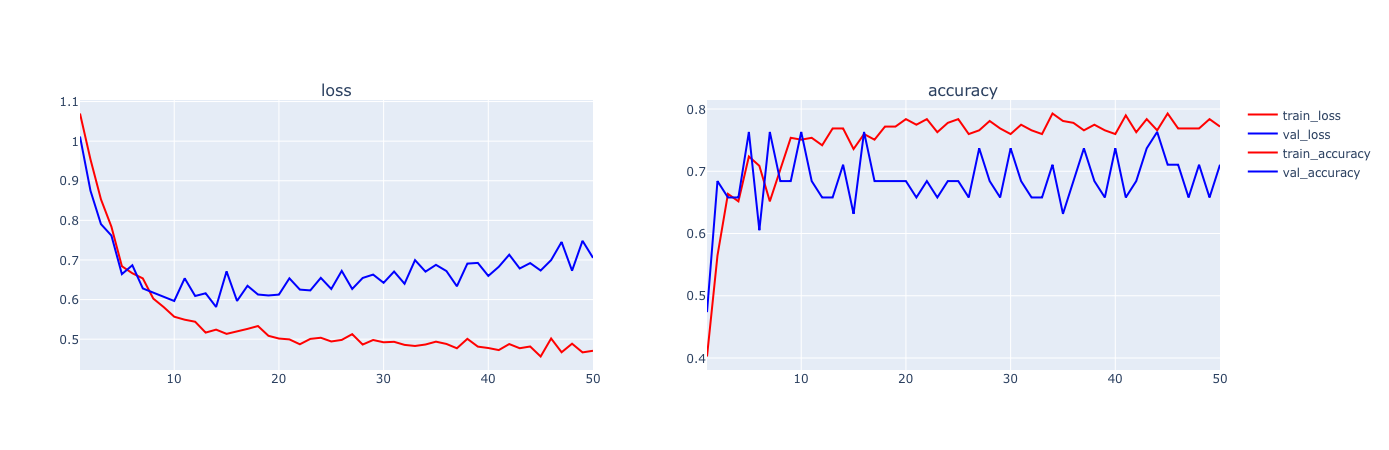

In [75]:
analyze(exproot="/Users/avilay/temp/experiments/ghosts-exp-1", run_name="green-leaf-4187")

In [77]:
df = compare("/Users/avilay/temp/experiments/ghosts-exp-1")

To plot using this dataframe:
fig = go.Figure(layout_title_text='Loss', layout_xaxis_title='Runs'
fig.add_bar(x=summary.run_names, y=summary.val_loss)



In [79]:
df.sort_values(by="val_accuracy", ascending=False)[:5]

,run_names,val_loss,val_accuracy,batch_size,n_epochs,lr,classifier
21,round-cherry-0112,0.783937,0.789474,16,100,0.005,4
14,floral-snow-0971,0.749506,0.763158,16,100,0.005,4
12,noisy-disk-9060,0.709507,0.736842,16,50,0.005,4
20,green-leaf-4187,0.705430,0.710526,32,50,0.005,5
4,red-frost-8136,0.699808,0.710526,16,50,0.005,4


`round-cherry-0112` seems like the best model. Train on the full training set with that hyperparams.

In [94]:
exp = StdoutMLExperiment("final")
trainer = tu.Trainer(exp, dataset, valset, [accuracy])
trainer.metrics_log_frequency = 50
hparams = MyHyperparams(batch_size=16, n_epochs=50, lr=0.005, classifier=4)
trainer.train(hparams, build_trainer)
trainer.final_metrics

Starting run curly-queen-7180
Starting run curly-queen-7180

Summary:
{'evaluation_metrics': {'val_accuracy': 0.763, 'val_loss': 0.394},
 'hyperparams': {'batch_size': 16,
                 'classifier': 4,
                 'lr': 0.005,
                 'n_epochs': 50}}

Step 50
	train_loss = 0.469
	train_accuracy = 0.763
	val_loss = 0.394
	val_accuracy = 0.763


{'val_loss': 0.3942246735095978, 'val_accuracy': 0.7631578947368421}

# Evaluate on Testset

In [84]:
test_df = pd.read_csv(path.join(DATAROOT, "test.csv"), index_col="id")

In [85]:
test_df.head()

,bone_length,rotting_flesh,hair_length,has_soul,color
id,,,,,
3,0.471774,0.387937,0.706087,0.698537,black
6,0.427332,0.645024,0.565558,0.451462,white
9,0.549602,0.491931,0.660387,0.449809,black
10,0.638095,0.682867,0.471409,0.356924,white
13,0.361762,0.583997,0.377256,0.276364,black


In [90]:
testX = test_df[["bone_length", "rotting_flesh", "hair_length", "has_soul"]]
testX.shape

(529, 4)

In [89]:
encoded_color = color_encoder.transform(test_df.color)
print(encoded_color.shape)
encoded_color[:5]

(529, 6)


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0]])

In [91]:
testX = np.concatenate((testX, encoded_color), axis=1)
testX[:5]

array([[0.47177445, 0.38793706, 0.70608662, 0.69853726, 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.42733226, 0.64502359, 0.56555791, 0.45146162, 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.54960189, 0.49193055, 0.66038749, 0.44980918, 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.63809497, 0.68286744, 0.47140899, 0.35692448, 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.36176224, 0.58399739, 0.3772565 , 0.27636395, 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [98]:
testX = t.from_numpy(testX).to(t.float32)

In [100]:
testy_hat = trainer.model(testX)

In [102]:
testy_hat[:5]

tensor([[-7.3491,  4.0805,  1.1309],
        [-1.7773, -0.3521,  0.1071],
        [-4.7589,  1.6822,  0.9918],
        [-0.9654, -0.7004, -0.4102],
        [ 3.0164, -5.1523, -0.2298]], grad_fn=<SliceBackward>)

In [103]:
testy_pred = t.argmax(testy_hat, dim=1)
testy_pred[:5]

tensor([1, 2, 1, 2, 0], grad_fn=<SliceBackward>)

In [106]:
test_type = type_encoder.inverse_transform(testy_pred.detach())

In [107]:
test_type.shape

(529,)

In [108]:
test_df["type"] = test_type

In [109]:
test_df.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
id,,,,,,
3,0.471774,0.387937,0.706087,0.698537,black,Ghoul
6,0.427332,0.645024,0.565558,0.451462,white,Goblin
9,0.549602,0.491931,0.660387,0.449809,black,Ghoul
10,0.638095,0.682867,0.471409,0.356924,white,Goblin
13,0.361762,0.583997,0.377256,0.276364,black,Ghost


In [111]:
test_df[["type"]].to_csv("/Users/avilay/mldata/ghosts/submission2.csv")